## Assignment 10

In this assignment I'm going to apply the machine learning, using different models, to the DataSet of the previouos one. This is useful to see which model predicts in the best way the AC consumption of the building.

First, I'm recalling all the data I need to solve the problem.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
ExternalFilesFolder =  r"C:\Users\Mirko\Desktop\Assigment10_MFerrari"
os.chdir(ExternalFilesFolder)
ConsumptionFileName= "consumption_5545.csv"
TemperatureFileName= "Austin_weather_2014.csv"
IrradianceFileName= "irradiance_2014_gen.csv"

path_consumptionFile = os.path.join(ExternalFilesFolder,ConsumptionFileName)
path_TemperatureFile = os.path.join(ExternalFilesFolder,TemperatureFileName)
path_IrradianceFile = os.path.join(ExternalFilesFolder,IrradianceFileName)

DF_consumption = pd.read_csv(path_consumptionFile,sep=",", index_col=0)
PreviousIndex = DF_consumption.index
NewParsedIndex= pd.to_datetime(PreviousIndex)
DF_consumption.index =NewParsedIndex 

DF_weather = pd.read_csv(path_TemperatureFile,sep=";",index_col=0)
previousIndex_weather=DF_weather.index
newIndex_weather=pd.to_datetime(previousIndex_weather)
DF_weather.index = newIndex_weather
DF_Temperature= DF_weather[["temperature"]]

DF_irradianceSource = pd.read_csv(path_IrradianceFile,sep=";",index_col=1)
DF_irradiance=DF_irradianceSource[["gen"]]
DF_irradiance[DF_irradiance["gen"]<0] = 0

DF_joined = DF_consumption.join([DF_Temperature,DF_irradiance])
DF_mod = DF_joined.copy()
DF_mod["temperature"] = DF_mod["temperature"].shift(-5)
DF_mod = DF_mod.rename(columns = {"air conditioner_5545":"AC_consumption","gen":"irradiance"})
DF_mod.dropna(inplace = True)

def lag_feature(df,column_name,lag_start,lag_end, lag_interval):
    for i in range(lag_start,lag_end +1, lag_interval):
        new_column_name = column_name + "-" + str(i) + "hr"
        df[new_column_name] = (df[column_name]).shift(i)
        df.dropna(inplace = True)
    return df

DF_mod = lag_feature(DF_mod,"temperature",1,6,1)
DF_mod = lag_feature(DF_mod,"irradiance",3,6,1)
DF_mod = lag_feature(DF_mod,"AC_consumption",1,24,1)

DF_mod["hour"] = DF_mod.index.hour
DF_mod["sin_hour"] = np.sin(DF_mod.index.hour*2*np.pi/24)
DF_mod["cos_hour"] = np.cos(DF_mod.index.hour*2*np.pi/24)
DF_mod["day_of_week"] = DF_mod.index.dayofweek
DF_mod["month"] = DF_mod.index.month
DF_mod["week_of_year"] = DF_mod.index.week

def WeekendDetector(day):
    if (day == 5 or day == 6):
        weekendLabel = 1
    else:
        weekendLabel = 0
    return weekendLabel

DF_mod["weekend"] = DF_mod["day_of_week"].apply(WeekendDetector)

def DayDetector(hour):
    if (hour < 19 and hour >= 9):
        DayLabel = 1
    else:
        DayLabel = 0
    return DayLabel

DF_mod["workingTime"] = DF_mod["hour"].apply(DayDetector)

DF_mod.describe()


,AC_consumption,temperature,irradiance,temperature-1hr,temperature-2hr,temperature-3hr,temperature-4hr,temperature-5hr,temperature-6hr,irradiance-3hr,...,AC_consumption-23hr,AC_consumption-24hr,hour,sin_hour,cos_hour,day_of_week,month,week_of_year,weekend,workingTime
count,8331.000000,8331.000000,8331.000000,8331.000000,8331.000000,8331.000000,8331.000000,8331.000000,8331.000000,8331.000000,...,8331.000000,8331.000000,8331.000000,8.331000e+03,8.331000e+03,8331.000000,8331.000000,8331.000000,8331.00000,8331.000000
mean,359.774542,68.445703,0.981319,68.445612,68.445691,68.445735,68.445888,68.446160,68.446639,0.981432,...,359.774542,359.774542,11.500300,1.656631e-04,-1.730291e-03,2.996159,6.706998,27.373665,0.28508,0.417717
std,665.390924,15.956914,1.423082,15.957079,15.956940,15.956862,15.956611,15.956177,15.955474,1.423036,...,665.390924,665.390924,6.914629,7.073443e-01,7.069519e-01,2.000056,3.304945,14.365165,0.45148,0.493213
min,0.000000,22.920000,0.000000,22.920000,22.920000,22.920000,22.920000,22.920000,22.920000,0.000000,...,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,0.000000,1.000000,1.000000,0.00000,0.000000
25%,0.000000,57.715000,0.000000,57.715000,57.715000,57.715000,57.715000,57.715000,57.715000,0.000000,...,0.000000,0.000000,6.000000,-7.071068e-01,-7.071068e-01,1.000000,4.000000,15.000000,0.00000,0.000000
50%,0.000000,71.360000,0.014450,71.360000,71.360000,71.360000,71.360000,71.360000,71.360000,0.014800,...,0.000000,0.000000,12.000000,1.224647e-16,-1.836970e-16,3.000000,7.000000,27.000000,0.00000,0.000000
75%,459.225000,79.940000,1.681108,79.940000,79.940000,79.940000,79.940000,79.940000,79.940000,1.681108,...,459.225000,459.225000,17.000000,7.071068e-01,7.071068e-01,5.000000,10.000000,40.000000,1.00000,1.000000
max,2841.000000,101.050000,5.099667,101.050000,101.050000,101.050000,101.050000,101.050000,101.050000,5.099667,...,2841.000000,2841.000000,23.000000,1.000000e+00,1.000000e+00,6.000000,12.000000,52.000000,1.00000,1.000000


Since now it was more or less what I did in the last assigment. It's time to go on with the new topic.

Since we're interested in AC consumption prediction, I'm using only the spring and summer months. The only output I want is the AC consumption, while all the other columns of my dataframe are inputs.

In [4]:
DF_mod = DF_mod["2014-03-01":"2014-09-30"]
DF_target = DF_mod["AC_consumption"]
DF_features = DF_mod.drop("AC_consumption", axis =1 )

With the following command, I'm importing the selection method based on training and test subsets, on which I'm later applying my model.

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(DF_features, DF_target, test_size = 0.2, random_state = 41234)

Among all the different models that are present, I'm now importing the linear regression one.

In [6]:
from sklearn import linear_model
linear_reg = linear_model.LinearRegression()

First, I want to **train** my model.

In [7]:
linear_reg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now I'm going to apply it on my dataframe, in order to **predict** the results.

In [8]:
predicted_linearReg_split = linear_reg.predict(X_test)
predicted_DF_linearReg_split = pd.DataFrame(predicted_linearReg_split, index = Y_test.index, columns =["AC_cons_predicted_linearReg_split"])
predicted_DF_linearReg_split = predicted_DF_linearReg_split.join(Y_test) 

With the lsat commands, I've created a new dataframe with 2 columns, one for the predicted values and the other for the real ones, so that I can easily compare them.

In [9]:
predicted_DF_linearReg_split.head()

,AC_cons_predicted_linearReg_split,AC_consumption
2014-03-10 22:00:00,-86.047548,0.000000
2014-03-15 06:00:00,43.761594,0.000000
2014-05-11 22:00:00,1524.350027,1230.183333
2014-04-10 19:00:00,220.126214,0.000000
2014-06-28 03:00:00,191.490588,464.400000


We can see that the model is not that accurate, it can predict pretty well if the consumption increases or decreases, but it predicts negative values and values which are far from the real ones.

We can plot the two columns in August to see graphically what happens.

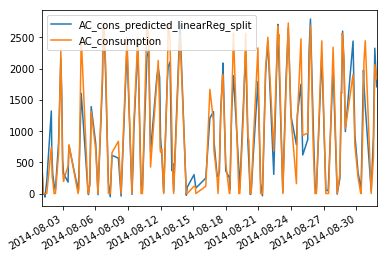

In [10]:
predicted_DF_linearReg_split_august = predicted_DF_linearReg_split["2014-08-01":"2014-08-31"]
plt.figure()
predicted_DF_linearReg_split_august.plot()
plt.show()
plt.close()

I want now to calculate numerically how accurate the predictions are. To do so, I'm importing again everything I need.

In [11]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

MAE_linearReg_split = mean_absolute_error(predicted_linearReg_split, Y_test)
MSE_linearReg_split = mean_squared_error(predicted_linearReg_split, Y_test)
R2_linearReg_split = r2_score(predicted_linearReg_split,Y_test)
print(R2_linearReg_split)

0.87578696798


It's not a bad number, but I can still try to improve it.

In this second case I'm going to use K-fold cross validation, in which test and training subsets are separated automatically.

In [12]:
from sklearn.model_selection import cross_val_predict

predict_linearReg_CV = cross_val_predict(linear_reg, DF_features, DF_target, cv =10)
predicted_DF_linearReg_CV = pd.DataFrame(predict_linearReg_CV, index = DF_target.index, columns =["AC_cons_predicted_linearReg_CV"])
predicted_DF_linearReg_CV = predicted_DF_linearReg_CV.join(DF_target)
predicted_DF_linearReg_CV

,AC_cons_predicted_linearReg_CV,AC_consumption
2014-03-01 00:00:00,-33.355920,0.000000
2014-03-01 01:00:00,-19.875506,0.000000
2014-03-01 02:00:00,-48.148625,0.000000
2014-03-01 03:00:00,-46.355230,0.000000
2014-03-01 04:00:00,-58.949130,0.000000
2014-03-01 05:00:00,-60.002895,0.000000
2014-03-01 06:00:00,-51.748881,0.000000
2014-03-01 07:00:00,-42.014322,0.000000
2014-03-01 08:00:00,-26.379783,0.000000
2014-03-01 09:00:00,-108.361269,0.000000


Graphically:

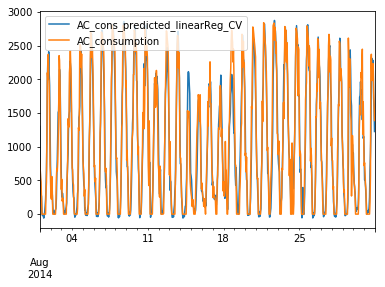

In [13]:
predicted_DF_linearReg_CV_august = predicted_DF_linearReg_CV["2014-08-01":"2014-08-31"]
plt.figure()
predicted_DF_linearReg_CV_august.plot()
plt.show(0)
plt.close()

From the graph I can state that this model fits better the real data with respect to the first one, but I can still improve it.

This time, numerically, I get:

In [14]:
MAE_linearReg_CV = mean_absolute_error(predict_linearReg_CV, DF_target)
MSE_linearReg_CV = mean_squared_error(predict_linearReg_CV, DF_target)
R2_linearReg_CV = r2_score(predict_linearReg_CV,DF_target)
print(R2_linearReg_CV)

0.878111346482


Which is a bit higher than in the first case.

I will now leave the linear model, and using the *forest* model instead.

In [15]:
from sklearn.ensemble import RandomForestRegressor

reg_RF = RandomForestRegressor()
predict_RF_CV = cross_val_predict(reg_RF, DF_features, DF_target, cv =10)
predicted_DF_RF_CV = pd.DataFrame(predict_RF_CV, index = DF_target.index, columns =["AC_cons_predicted_RF_CV"])
predicted_DF_RF_CV = predicted_DF_RF_CV.join(DF_target)
predicted_DF_RF_CV


,AC_cons_predicted_RF_CV,AC_consumption
2014-03-01 00:00:00,0.000000,0.000000
2014-03-01 01:00:00,0.000000,0.000000
2014-03-01 02:00:00,0.000000,0.000000
2014-03-01 03:00:00,0.000000,0.000000
2014-03-01 04:00:00,0.000000,0.000000
2014-03-01 05:00:00,0.000000,0.000000
2014-03-01 06:00:00,0.000000,0.000000
2014-03-01 07:00:00,0.000000,0.000000
2014-03-01 08:00:00,0.000000,0.000000
2014-03-01 09:00:00,0.000000,0.000000


In this case I don't have anymore the problem of negative predicted values, and in general the numbers are more similar each other. Let's see it graphically:

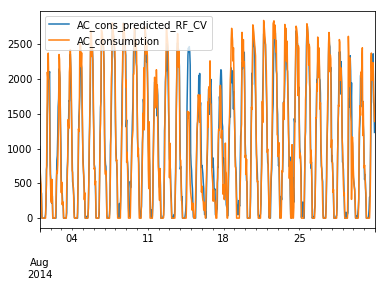

In [16]:
predicted_DF_RF_CV_august = predicted_DF_RF_CV["2014-08-01":"2014-08-31"]
plt.figure()
predicted_DF_RF_CV_august.plot()                                                                           
plt.show(0)
plt.close()

In this case the fitting is almost perfect everywhere, except for some points ( the accuracy can't be 100%, maybe in those days people were not in the bulding, or something else happened. **The model cannot predict this** ).

Numerically: 

In [17]:
MAE_RF_CV = mean_absolute_error(predict_RF_CV, DF_target)
MSE_RF_CV = mean_squared_error(predict_RF_CV, DF_target)
R2_RF_CV = r2_score(predict_RF_CV,DF_target)
print(R2_RF_CV)

0.901728503871


Which is higher than the other ones.

I want now to use continuous learning, which is more complex and takes more time, but it's more accurate.

In [18]:
DF_onlineConsumptionPrediction = pd.DataFrame(index = DF_mod.index)

As trainig period, I chose 30 days.

In [19]:
period_of_training = pd.Timedelta(30, unit ="d")

The first prediction will be done after 30 days (training period) from the first day considered ( 2014 - 03 - 01 ).

In [20]:
FirstTimeStamp_measured = DF_mod.index[0]
LastTimeStamp_measured = DF_mod.index[-1] 
FirstTimeStamp_toPredict = FirstTimeStamp_measured + period_of_training

training_startTimeStamp = FirstTimeStamp_measured
trainig_endTimeStamp = FirstTimeStamp_toPredict   

timeStamp_toPredict = FirstTimeStamp_toPredict

In the following command, *truncate* erases all the data before the first one to predict.

In [21]:
DF_onlineConsumptionPrediction = DF_onlineConsumptionPrediction.truncate(before = trainig_endTimeStamp) 

I'm now creating a **while loop** which train and test the model, hour by hour, updating meantime the corresponding time intervals. In this case linear regression is used to model.

In [22]:
while (timeStamp_toPredict < LastTimeStamp_measured ):  
    DF_feature_train = DF_features.truncate(before = training_startTimeStamp, after = trainig_endTimeStamp)         # tronca tutto quello prima di before e tutto quello dopo after
    DF_target_train = DF_target.truncate(before = training_startTimeStamp, after = trainig_endTimeStamp)

    DF_feature_test = DF_features.loc[timeStamp_toPredict].values.reshape(1,-1)
    DF_target_test = DF_target.loc[timeStamp_toPredict]
    
    linear_reg.fit(DF_feature_train,DF_target_train)
    predicted_Consumption = linear_reg.predict(DF_feature_test)
    DF_onlineConsumptionPrediction.loc[timeStamp_toPredict,"Predicted"] = predicted_Consumption
    DF_onlineConsumptionPrediction.loc[timeStamp_toPredict,"Real"] = DF_target_test
    
    timeStamp_toPredict = timeStamp_toPredict + pd.Timedelta(1, unit = "h")
    trainig_endTimeStamp = trainig_endTimeStamp + pd.Timedelta(1, unit = "h")
    training_startTimeStamp = training_startTimeStamp + pd.Timedelta(1, unit = "h")

In [23]:
DF_onlineConsumptionPrediction.dropna(inplace = True)

In [24]:
DF_onlineConsumptionPrediction

,Predicted,Real
2014-03-31 00:00:00,-0.109612,0.000000
2014-03-31 01:00:00,-31.672255,0.000000
2014-03-31 02:00:00,2.411096,0.000000
2014-03-31 03:00:00,-1.224687,0.000000
2014-03-31 04:00:00,18.927967,0.000000
2014-03-31 05:00:00,14.497143,0.000000
2014-03-31 06:00:00,1.036106,0.000000
2014-03-31 07:00:00,6.906795,0.000000
2014-03-31 08:00:00,4.605525,0.000000
2014-03-31 09:00:00,-6.129362,0.000000


In [25]:
R2_score_online_linearReg = r2_score(DF_onlineConsumptionPrediction[["Real"]],DF_onlineConsumptionPrediction[["Predicted"]])
print(R2_score_online_linearReg)

0.914880353853


We can see that the R2 values is even higher than the one obtained before with the *forest* model. Graphically:

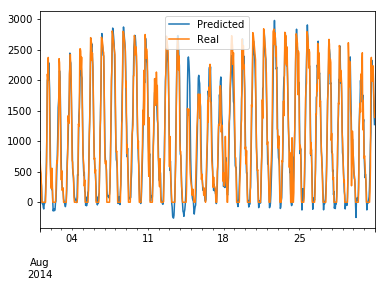

In [26]:
DF_onlineConsumptionPrediction_august = DF_onlineConsumptionPrediction["2014-08-01":"2014-08-31"]
plt.figure()
DF_onlineConsumptionPrediction_august.plot()                                                                           
plt.show(0)
plt.close()

Still, we can see that in some points the predictions are very poor.

I'll now use the trees to train the model. It will take a longer time to execute, but it will be more accurate.

In [27]:
FirstTimeStamp_measured = DF_mod.index[0]
LastTimeStamp_measured = DF_mod.index[-1] 
FirstTimeStamp_toPredict = FirstTimeStamp_measured + period_of_training

training_startTimeStamp = FirstTimeStamp_measured
trainig_endTimeStamp = FirstTimeStamp_toPredict   

timeStamp_toPredict = FirstTimeStamp_toPredict

In [28]:
while (timeStamp_toPredict < LastTimeStamp_measured ):   
    DF_feature_train = DF_features.truncate(before = training_startTimeStamp, after = trainig_endTimeStamp)         # tronca tutto quello prima di before e tutto quello dopo after
    DF_target_train = DF_target.truncate(before = training_startTimeStamp, after = trainig_endTimeStamp)

    DF_feature_test = DF_features.loc[timeStamp_toPredict].values.reshape(1,-1)
    DF_target_test = DF_target.loc[timeStamp_toPredict]
    
    reg_RF.fit(DF_feature_train,DF_target_train)
    predicted_Consumption = reg_RF.predict(DF_feature_test)
    DF_onlineConsumptionPrediction.loc[timeStamp_toPredict,"Predicted"] = predicted_Consumption
    DF_onlineConsumptionPrediction.loc[timeStamp_toPredict,"Real"] = DF_target_test
    

    timeStamp_toPredict = timeStamp_toPredict + pd.Timedelta(1, unit = "h")
    trainig_endTimeStamp = trainig_endTimeStamp + pd.Timedelta(1, unit = "h")
    training_startTimeStamp = training_startTimeStamp + pd.Timedelta(1, unit = "h")

DF_onlineConsumptionPrediction.dropna(inplace = True)


In [29]:
DF_onlineConsumptionPrediction

,Predicted,Real
2014-03-31 00:00:00,0.000000,0.000000
2014-03-31 01:00:00,0.000000,0.000000
2014-03-31 02:00:00,0.000000,0.000000
2014-03-31 03:00:00,0.000000,0.000000
2014-03-31 04:00:00,0.000000,0.000000
2014-03-31 05:00:00,0.000000,0.000000
2014-03-31 06:00:00,0.000000,0.000000
2014-03-31 07:00:00,0.000000,0.000000
2014-03-31 08:00:00,0.000000,0.000000
2014-03-31 09:00:00,0.000000,0.000000


In [30]:
R2_score_online_RF = r2_score(DF_onlineConsumptionPrediction[["Real"]],DF_onlineConsumptionPrediction[["Predicted"]])
print(R2_score_online_RF)

0.983334280885


I can state that this one is the best fit I've done since now. Graphically:

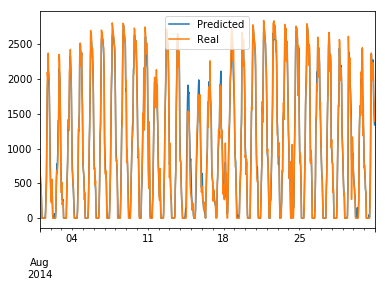

In [31]:
DF_onlineConsumptionPrediction_august = DF_onlineConsumptionPrediction["2014-08-01":"2014-08-31"]
plt.figure()
DF_onlineConsumptionPrediction_august.plot()                                                                           
plt.show(0)
plt.close()

We can see that the predicted values almost fit perfectly the real ones this time, except for very few points.